#Import#

In [ ]:
import tensorflow as tf
import pickle
import joblib
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

from keras.datasets import cifar10, cifar100
from tensorflow.keras import Model,activations, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LeakyReLU, Dropout, Flatten, Dense, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, ZeroPadding2D, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import CosineDecay, PiecewiseConstantDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

from pylab import rcParams


from typing import Sequence, Union, Tuple

#Options and Device#

In [ ]:
# Setting options for the tf.data.Dataset
options = tf.data.Options()
options.experimental_optimization.noop_elimination = True # eliminate no-op transformations
options.experimental_optimization.apply_default_optimizations = False # do not apply default graph optimizations
options.experimental_optimization.map_fusion=True # fuse map transformations
options.experimental_optimization.parallel_batch = True # parallelize copying of batch elements

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

AUTOTUNE = tf.data.AUTOTUNE

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Hyperparameter setting#

In [ ]:
# 10 for cifar10
dataset_type = 10

#"strided convolution","fixed spectral pooling" or "diffstride"
type_downsampling = "diffstride"

# 1 (strided convolution), 2(fixed spectral pooling), 3(diffstride)
if type_downsampling == "strided convolution":
  method = 1
elif type_downsampling == "fixed spectral pooling":
  method = 2
else:
  method = 3
print("The chosen method for the training is the number: ", method, " = ", type_downsampling)

BATCH_SIZE = 128  #256

stride_used =   [2, 2, 2]     # [3, 1, 3]  #[2, 2, 3]  # [3, 1, 2]  

epochs = 150

# network paramenters
filter_size = [64, 128, 256, 512]
if method == 1:
  stride_n = stride_used
else:
  stride_n = [1,1,1]
print("Initialization of the strides used in the convolutional layers to the values of: ", stride_n)

s_residual = stride_used
print("Strides used in the 3 residual blocks of the Resnet18, in our custom layers (only if method 2 or 3): ", s_residual)


# SGD optimizer parameters
boundaries = [400, 18_000, 32_000]
values = [0.01, 0.1, 0.01, 0.001]
label_smoothing = 0.2
momentum = 0.9

The chosen method for the training is the number:  3  =  diffstride
Initialization of the strides used in the convolutional layers to the values of:  [1, 1, 1]
Strides used in the 3 residual blocks of the Resnet18, in our custom layers (only if method 2 or 3):  [2, 2, 2]


#Dataset#

##Dataset Loading#

The following function "load_dataset" is used in order to download from the internet the cifar datasets.

In [ ]:
def load_dataset(name:int):
  
  if name==10:
    (trainX, trainY),(val_test_X, val_test_Y)=cifar10.load_data()
  elif name==100:
    (trainX, trainY), (val_test_X, val_test_Y) = cifar100.load_data()
  else:
    print("Wrong dataset")

  valX, testX = tf.split(val_test_X, 2, axis=0)
  valY, testY = tf.split(val_test_Y, 2, axis=0)

	# one hot encode target values
  trainY = to_categorical(trainY)
  valY = to_categorical(valY)
  testY = to_categorical(testY)

  return trainX, trainY, valX, valY, testX, testY

##Dataset Analysis

###CIFAR-10###

The cifar 10 dataset is downloaded from: https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset consists of 60.000 32x32 coloured images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), with 6.000 images per class. There are 50.000 training images and 10.000 test images. \\
The dataset is divided into batches (each batch is made up of 10.000 images):
*   1 test batch (that here we use both for validation and test).It contains exactly 1.000 randomly-selected images from each class.
*   5 training batches. They contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them all, the training batches contain exactly 5.000 images from each class.

170508288/170498071 [==============================] - 6s 0us/step

In train set we have 50.000 images. Each image of X is a 32x32 pixels coloured(x3) image.
The Y contains the 50.000 labels, which have been one-hot encoded.
    Train: X=(50000, 32, 32, 3), Y=(50000, 10)
In test set we have 10.000 images. Each image of X is a 32x32 pixels coloured(x3) image.
    Validation: X=(5000, 32, 32, 3), Y=(5000, 10)
    Test: X=(5000, 32, 32, 3), Y=(5000, 10)

First 9 images in the cifar10 dataset: 


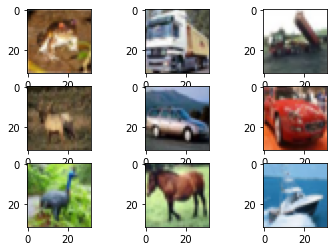

In [ ]:
trainX_cifar10, trainY_cifar10, valX_cifar10, valY_cifar10, testX_cifar10, testY_cifar10 = load_dataset(name=10)

# summarize loaded dataset
print("\nIn train set we have 50.000 images. Each image of X is a 32x32 pixels coloured(x3) image.")
print("The Y contains the 50.000 labels, which have been one-hot encoded.")
print('    Train: X=%s, Y=%s' % (trainX_cifar10.shape, trainY_cifar10.shape))
print("In test set we have 10.000 images. Each image of X is a 32x32 pixels coloured(x3) image.")
print('    Validation: X=%s, Y=%s' % (valX_cifar10.shape, valY_cifar10.shape))
print('    Test: X=%s, Y=%s' % (testX_cifar10.shape, testY_cifar10.shape))


# plot first few images
print("\nFirst 9 images in the cifar10 dataset: ")
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX_cifar10[i])
# show the figure
plt.show()


##Dataset creation#

The data from the cifar dataset have been organized through a tf.data.Dataset. \\
First data have been prepared in the "prepare_dataset" function. Then the "create_dataset" function creates the tf.dataset.

###Data preparation and augmentation###

First, the image is normalized wrt the mean and the standard deviation of the dataset. Each dataset has its own std and mean: 

*   cifar10: $mean=[0.4914, 0.4822, 0.4465]$, $std=[0.2470, 0.2435, 0.2616]$
*   cifar100: $mean=[0.5071, 0.4867, 0.4408]$, $std=[0.2675, 0.2565, 0.2761]$

Normalization was performed by passing the mean and variance (computed as the square of the std) to a tf.keras.layers.Normalization. \\
We also denormalized in order to check that the normalization was performed correctly. Denormalization is performed by using again the Normalization layer, to which are passed a $mean_{denorm} = - mean/std$ and a $std_{denorm}=1/std$.

Now, if we are creating the test dataset, the normalized image and its label are returned. Otherwise, the image:
 is padded, randomly cropped and randomly 

*   is padded with zeros to the specified height and width (that here are incremented of 4 wrt the original height and width of the images in the dataset);
*   is randomly cropped;
*   is randomly flipped left to right.

Finally, the modified image and its label are returned.

We have done also some trials using a different augmentation that exploits the mixup technique but it resulted in a lower classification accuracy. The mixup technique consists in mixing up two images in order to get a third image. The two images contribute to the resulting image with different weights which are randomly selected. Thanks to the "yield" instruction we can return either the mixup image or the two original images, when we decide not to perform the mixup technique





In [ ]:
class prepare_dataset:

    # padding, cropping and flipping
    def pad_crop_flip(self, image: tf.Tensor, pad_size: int = 2) -> tf.Tensor:
      """Data augmentation: Random shifts and flips."""
      shape = image.shape
      height, width = shape[:2] 
      image = tf.image.pad_to_bounding_box(image, pad_size, pad_size,
                                          height + 2 * pad_size,
                                          width + 2 * pad_size)
      image = tf.image.random_crop(image, shape)
      image = tf.image.random_flip_left_right(image)
      return image


    
    def sample_beta_distribution(self, size: int,
                             concentration_0: float = 0.2,
                             concentration_1: float = 0.2):
        """Samples from a beta distribution."""
        gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
        gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
        return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


    # https://keras.io/examples/vision/mixup/
    # ricorda che labels è un array di one-hot encoding array
    # weight=0.5, mixo pera = [1,0,0] cavallo = [0,1,0], pera+cavallo = [0.5,0.5,0]
    def mix_up(self, image1: tf.Tensor, label1: tf.Tensor, image2: tf.Tensor, label2: tf.Tensor, alpha: float = 0.2):

      image1 = tf.cast(image1, tf.float32)
      image2 = tf.cast(image2, tf.float32)
      label1 = tf.cast(label1, tf.float32)
      label2 = tf.cast(label2, tf.float32)

      # Sample lambda and reshape it to do the mixup
      weight = self.sample_beta_distribution(1, alpha, alpha)[0]

      # Perform mixup on both images and labels by combining a pair of images/labels
      # (one from each dataset) into one image/label
      mixed_image = image1 * weight + image2 * (1 - weight)
      mixed_label = label1 * weight + label2 * (1 - weight)

      return mixed_image, mixed_label



    def augment_data(self, img: tf.Tensor,lab: tf.Tensor):
        r = random.randint(0,10)
        if 0 <= r and r <= 4: 
          img_aug = self.pad_crop_flip(img)
          lab_aug = lab
        elif 4 < r and r <= 7:
          img_aug, lab_aug = self.mix_up(img,lab)
        else:
          img_aug = img
          lab_aug = lab
        return img_aug, lab_aug

    # a good practice is to normalize each image in the dataset wrt the mean and the std of the dataset. Each dataset has its own std and mean
    def normalization(self, image: tf.Tensor) -> tf.Tensor:

      image = tf.cast(image, tf.float32) / tf.uint8.max

      if dataset_type == 10:  #cifar10
        mean_d = [0.4914, 0.4822, 0.4465]
        variance_d = [np.square(0.2470), np.square(0.2435), np.square(0.2616)]  # I square the values of the std in order to compute the variance
      else:   #cifar100
        mean_d = [0.5071, 0.4867, 0.4408]
        variance_d = [np.square(0.2675), np.square(0.2565), np.square(0.2761)]

      norm_layer = tf.keras.layers.Normalization(mean=mean_d, variance=variance_d)
      
      image_norm = norm_layer(image)

      return image_norm


    def denormalize(self, image: tf.Tensor) -> tf.Tensor:

      if dataset_type == 10:  #cifar10
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2470, 0.2435, 0.2616]
      else:   #cifar100
        mean = [0.5071, 0.4867, 0.4408]
        std = [0.2675, 0.2565, 0.2761]


      mean1 = [-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]]
      std1 = [1/std[0], 1/std[1], 1/std[2]]

      norm_layer = tf.keras.layers.Normalization(mean=mean1, 
                      variance=[np.square(std1[0]), 
                                np.square(std1[1]), 
                                np.square(std1[2])]) 
      img_denorm = norm_layer(image)

      return img_denorm



    # prende in input un'immagine e la corrispondente label (se cycle_length=2 prende in input due immagini e due labels)
    def __call__(self, file, lab, test):   

      img1 = file[0]
      label1 = lab[0]   
      img2 = file[1]
      label2 = lab[1] 

      image1 = self.normalization(img1)
      image2 = self.normalization(img2)
      #img_denorm1 = self.denormalize(img_norm1)  # used to check that the normalization was performed correctly
      #img_denorm2 = self.denormalize(img_norm2)  # used to check that the normalization was performed correctly

      if not test:
        image1 = self.pad_crop_flip(image1)
        image2 = self.pad_crop_flip(image2)
        #img3, label3 = self.mix_up(image1, label1, image2, label2)

      if not test:
        yield image1, label1
        yield image2, label2
        #yield img3, label3
      else: #test
        yield image1, label1
        yield image2, label2

###tf.Data.dataset###

We use *from_tensor_slices* in order to create couples <image,label> and we decide to set the batch to 2 to perform the mixup.

With *interleave* we are able to call *prepare_dataset* to perform data augmentation for each sample in the dataset.

We perform also the shuffle to have data in a non-deterministic random order.

Then the batch size is applyed and so we get a dataset where each element is composed of BATCH_SIZE couples.

In [ ]:
def create_dataset(filenamesX, filenamesY, test=False):
    dataset = tf.data.Dataset.from_tensor_slices((filenamesX, filenamesY)).batch(2) 
    
    if not test:
        dataset = dataset.with_options(options)
    
    
    gpu_transform = tf.data.experimental.prefetch_to_device('/gpu:0')

    block_length = 1
    
    '''
    if test:
        block_length = 1
    else:
        block_length = 1
    '''

    # https://stackoverflow.com/questions/62105896/how-to-use-tf-data-dataset-interleave-in-tf-2-with-a-custom-function
    dataset = dataset.interleave(lambda filename, lab: tf.data.Dataset.from_generator(
                                prepare_dataset(), 
                                output_signature=(
                                    tf.TensorSpec(shape=(32,32, 3), dtype=tf.float32),
                                    tf.TensorSpec(shape=(dataset_type,), dtype=tf.float32)),
                                args=(filename, lab, test)),
                                num_parallel_calls=AUTOTUNE,
                                cycle_length=1, block_length=block_length,deterministic=False)

    dataset = dataset.cache()
    
    if not test:
        dataset = dataset.shuffle(buffer_size=1000) 

    dataset = dataset.batch(BATCH_SIZE) 
    dataset = dataset.apply(gpu_transform)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

Here we create train, validation and test datasets.

In [ ]:
if dataset_type == 10:
  train_dataset = create_dataset(trainX_cifar10, trainY_cifar10)
  val_dataset = create_dataset(valX_cifar10, valY_cifar10)
  test_dataset = create_dataset(testX_cifar10, testY_cifar10, test=True)
  print("Dataset CIFAR 10 created !")
else:
  print("Wrong dataset type")

Dataset CIFAR 10 created !


In [ ]:
print("Number of batches of 128 couples <image, label> (only the last batch will be smaller) in the train dataset: ", len(list(train_dataset)))
print("Number of batches of 128 couples <image, label> (only the last batch will be smaller) in the validation dataset: ", len(list(val_dataset)))
print("Number of batches of 128 couples <image, label> (only the last batch will be smaller) in the test dataset: ", len(list(test_dataset)))

Number of batches of 128 couples <image, label> (only the last batch will be smaller) in the train dataset:  391
Number of batches of 128 couples <image, label> (only the last batch will be smaller) in the validation dataset:  40
Number of batches of 128 couples <image, label> (only the last batch will be smaller) in the test dataset:  40


#Network#

###Implementation of the Fixed Spectral Pooling layer (for method 2)###

This class is used to create the fixed spectral pooling layer which alleviates the loss of information of spatial pooling. 

It takes as input a non-first channel data so the first thing done here is to transpose the tensor in a channel first format because necessary for applying *rfft2d* function. In fact this layer works in the frequency domain: there is a fixed-size bounding box that crops the frequency version of the image.

At the end the image is brought back in the real domain and re-transpose in non-channel first.

More details about the implementation of the method, are explained through the comments in the code below.

In [ ]:
# (method = 2)
# fixed spectral pooling layer
class fixed_spectral_pool(tf.keras.layers.Layer):    
  
  def __init__(self, strides: Tuple[float, float] = (2.0, 2.0))  -> tf.Tensor:
    super(fixed_spectral_pool, self).__init__()
    self._strides = strides

  def build(self, input_shape):  #input_shape is channel first

    # compute height and width of the input image 
    h_img = input_shape[1]
    w_img = input_shape[2]
    
    # add_weight is a method for layers, and it creates a TensorFlow variable representing some mutable value in the layer
    # since trainable=false, backpropagation won't change its value
    self.strides = self.add_weight( shape=(2,), initializer=tf.initializers.Constant(self._strides),
                                    trainable=False, dtype=tf.float32, name='strides')
    
    # size of the bounding box
    h_bb = h_img // self.strides[0]
    h_bb -= h_bb % 2   #if the h_bb (strided height) is an odd number, it subtracts 1, obtaining an even number
    
    w_bb = w_img // self.strides[1]

    # in order to avoid collapse, the strided height and width need to have minimum value = 2
    h_bb = tf.math.maximum(h_bb, 2)
    w_bb = tf.math.maximum(w_bb, 2)

    # starting from the size of the bounding box, compute values that will be used to crop in the frequency domain 
    lower_h = h_bb // 2 
    upper_h = h_img - lower_h
    upper_w = w_bb // 2 + 1

    self.output_shap = [int(h_bb), int(w_bb)]  
    self.limits = [int(lower_h), int(upper_h), int(upper_w)] 

  
  def call(self, inputs: tf.Tensor, training:bool=False):  #takes in input a non-channel first tensor
    inputs = tf.transpose(inputs, (0, 3, 1, 2))

    batch_size, input_channels = inputs.shape.as_list()[:2]
    lower_height, upper_height, upper_width = self.limits
    output_height, output_width = self.output_shap

    inputs = tf.cast(inputs, tf.float32)  

    # we pass into the frequency domain
    fourier_inputs = tf.signal.rfft2d(inputs) 

    # concatenation is used in order to crop the frequency image in the part which is positive in width and zero-centered in height
    output = tf.concat([fourier_inputs[:, :, :lower_height, :upper_width],
                      fourier_inputs[:, :, upper_height:, :upper_width]],
                      axis=2)
    
    # we convert the image in the real numbers domain
    reale = tf.ensure_shape( tf.signal.irfft2d(output, fft_length=[output_height, output_width]), [batch_size, input_channels, output_height, output_width])
    reale = tf.transpose(reale, (0, 2, 3, 1))

    return reale

###Implementation of the Learnable Spectral Pooling layer (Diffstride, method 3)###

This class is used to create the learnable spectral pooling layer which addresses the difficulty of searching stride parameters. This method in fact, instead of using a fixed bounding box, learns the box size via backpropagation.
 The learnable box is parametrized by the shape of the input, a smoothness factor R and the strides. 

It takes as input a non-first channel data so the first thing done here is to transpose the tensor in a channel first format because necessary for applying *rfft2d* function. In fact also this layer works in the frequency domain: the learned bounding box crops the frequency version of the image. 

The bounding box (mask) is computed as the outer product between two differentiable 1D masking functions, one along the vertical axis and one along the horizontal axis. The respective formulas to compute them are:

Formula $(1)$:  $mask_h = min[max[\frac{1}{R} (R + \frac{H}{2S_h} - |\frac{H}{2}-m|), 0], 1]$  , $m \in [0, H]$    \\
Formula $(2)$:   $mask_w = min[max[\frac{1}{R} (R + \frac{W}{2S_w} - n), 0], 1]$  , $n \in [0, \frac{W}{2}+1]$    \\

Then the part of the image (in the frequency domain) that is outside the mask is cropped. Finally the image is brought back in the real domain and re-transpose in non-channel first.

More details about the implementation of the method, are explained through the comments in the code below.

In [ ]:
#Diffstride (method=3)
# learnable spectral pooling layer

class diffstride_spectral_pool(tf.keras.layers.Layer):    
  
  def __init__(self, strides: Tuple[float, float] = (2.0, 2.0), smoothness_factor: float = 4.0, trainable_strides: bool = True)  -> tf.Tensor:
    super(diffstride_spectral_pool, self).__init__()
    self.init_strides = strides
    self.smoothness_factor = smoothness_factor
    self.trainable_strides = trainable_strides  # here True, because the backpropagation changes the value of the strides during training

    # the value of the strides has to remain >= 1
    if self.init_strides[0]<1 or self.init_strides[1]<1:
      raise ValueError(f'Strides values < 1. Use a values bigger or equal to 1!')
    if self.smoothness_factor < 0:
      raise ValueError(f'Smoothness factor < 0. Use a value bigger or equal to 0!')

  def build(self, input_shape):
    
    # add_weight is a method for layers, and it creates a TensorFlow variable representing some mutable value in the layer
    # since trainable=true, backpropagation will train this variable, changing its value during the training
    self.strides = self.add_weight( shape=(2,), initializer=tf.initializers.Constant(self.init_strides), 
                                    trainable=self.trainable_strides, dtype=tf.float32, name='strides')


  def call(self, inputs: tf.Tensor, training:bool=False):  #takes in input a non-channel first tensor

    inputs = tf.transpose(inputs, (0, 3, 1, 2))

    batch_size = inputs.shape[0]
    input_channels = inputs.shape[1]
    height, width = tf.shape(inputs)[2], tf.shape(inputs)[3]   # height and width of the input images

  
    upper_w = width // 2 + 1  # upper limit of the interval formula (2)
    upper_h = height   # upper limit of the interval formula (1)

    # intervals of m, n. formulas (1) (2)
    n_interval = tf.range(upper_w, dtype=tf.float32)   # n belongs [0, W/2+1]
    m_interval = tf.range(upper_h, dtype=tf.float32)  # m belongs [0, H]

    w_pos = n_interval
    h_pos = tf.math.abs(tf.cast(height//2, tf.float32) - m_interval)


    # we compute the minimum values acceptable for the strides
    # they have to be always >= 1: here is ensured by the fact that the numerator is always bigger than the denominator
    min_h_stride = tf.cast(height, tf.float32) / (tf.cast(height, tf.float32) - self.smoothness_factor)
    min_w_stride = tf.cast(width, tf.float32) / (tf.cast(width, tf.float32) - self.smoothness_factor)

    if self.strides[0] < min_h_stride:
      self.strides[0].assign(min_h_stride)
    if self.strides[1] < min_w_stride:
      self.strides[1].assign(min_w_stride)

    h_stride = tf.clip_by_value(self.strides[0], 1.0, tf.float32.max)   # vertical stride
    w_stride = tf.clip_by_value(self.strides[1], 1.0, tf.float32.max)   # horizontal stride
    

    # The strides have to be at least of value 2: it is the minimum value to avoid collapse of the feature map.
    strided_height = tf.math.maximum( tf.cast(height, tf.float32)/h_stride , 2.0 )   # H / S_h
    strided_width = tf.math.maximum( tf.cast(width, tf.float32) / w_stride , 2.0 )   # W / S_w

    lower_h = strided_height / 2.0      # H / 2*S_h
    upper_w = strided_width / 2.0 + 1.0  # ( W / 2*S_w )  + 1



    # COMPUTATION OF THE 1D MASKS
    # upper_w is the Threshold that starts the ramp. #smoothness_factor is the smoothness of the ramp (R in the paper)
    # pos: Position indices.
    
    # VERTICAL MASK (formula (1))
    h_mask_noCast = (1.0 / self.smoothness_factor) * (self.smoothness_factor + lower_h - h_pos)
    
    # HORIZONTAL MASK (formula (2))
    w_mask_noCast = (1.0 / self.smoothness_factor) * (self.smoothness_factor + upper_w - w_pos)
    
    
    
    # the clipping between 0 and 1 is equivalent to do the following two operations: 
    # x = max(mask_noCast, 0)
    # mask = min(x, 1)
    w_mask = tf.cast(tf.clip_by_value(w_mask_noCast, 0.0, 1.0), dtype=tf.complex64)
    h_mask = tf.cast(tf.clip_by_value(h_mask_noCast, 0.0, 1.0), dtype=tf.complex64)   
    h_mask = tf.signal.fftshift(h_mask)   # Shift the zero-frequency component to the center of the spectrum.
    

    # we pass into the frequency domain
    fourier_inputs = tf.signal.rfft2d(inputs) 
    
    # COMPUTATION OF THE TOTAL MASK
    # element wise product between the frequency input and the total mask (total_mask = h_mask * w_mask)
    output = fourier_inputs * w_mask[None, None, None, :]
    output = output * h_mask[None, None, :, None]


    # the cropping operation isn't differentiable wrt strides. So it is necessary to apply a stop
    # gradient operator, to the mask before cropping.
    w_to_keep = tf.stop_gradient( tf.where(tf.cast(w_mask, tf.float32) > 0.)[:, 0] )
    h_to_keep = tf.stop_gradient( tf.where(tf.cast(h_mask, tf.float32) > 0.)[:, 0] )

    # cropping (we gather only the parts of the image we're interested into)
    output = tf.gather(output, indices=h_to_keep, axis=2)
    output = tf.gather(output, indices=w_to_keep, axis=3)


    # we convert the image in the real numbers domain
    reale = tf.ensure_shape( tf.signal.irfft2d(output), [batch_size, input_channels, None, None])
    reale = tf.transpose(reale, (0, 2, 3, 1))

    return reale

###Identity and Residual blocks, used in ResNet18###

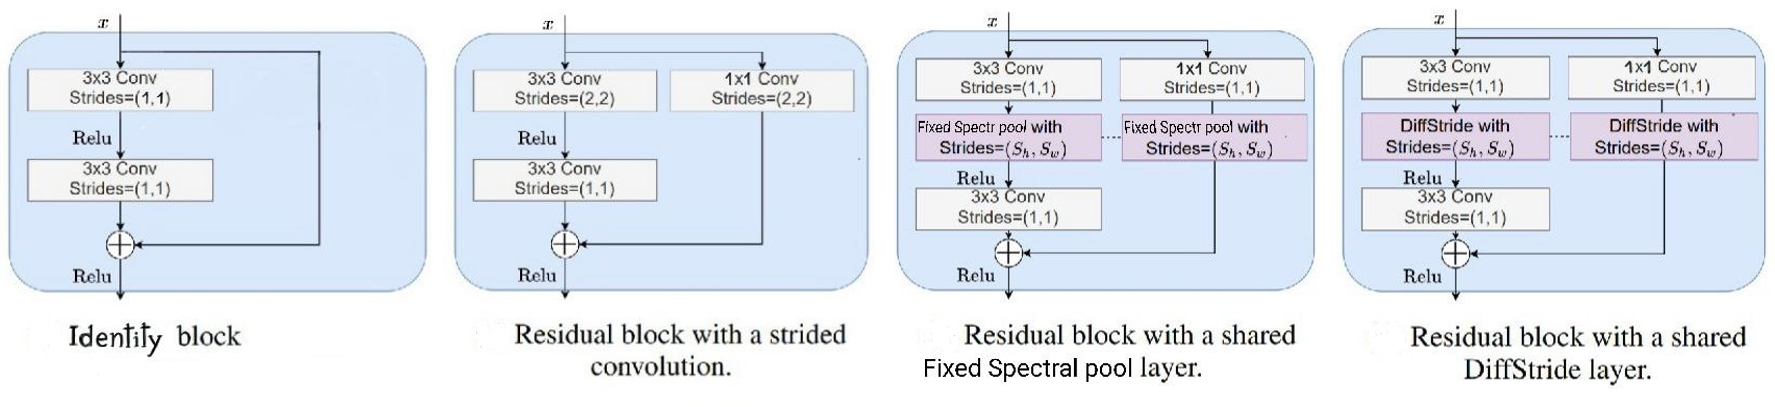

In [ ]:
#doesn't change in the 3 different pooling methods implemented, in fact no stride is applied here

def identity_block(x, filter,nm):  #x, filter_size[i]
  # copy tensor to variable called x_skip
  x_skip = x
  # Layer 1
  x = Conv2D(filter, (3,3), padding = 'same', name="Conv2D_"+nm+("_1...IB"))(x)
  x = BatchNormalization(axis=3, name="BatchNormalization_"+nm+("_1...IB"))(x)
  x = ReLU(name="Relu_"+nm+("_1...IB"))(x)

  # Layer 2
  x = Conv2D(filter, (3,3), padding = 'same', name="Conv2D_"+nm+("_2...IB"))(x)
  x = BatchNormalization(axis=3, name="BatchNormalization_"+nm+("_2...IB"))(x)

  # Add Residue
  x = tf.keras.layers.Add(name="Add_"+nm+("...IB"))([x, x_skip])     
  x = ReLU(name="Relu_"+nm+("...IB"))(x)

  return x

In [ ]:
def residual_block(x, filter, s, s_pool, nm):

    if method==2:
      fixed2 = fixed_spectral_pool()
    elif method==3:
      diffstride2 = diffstride_spectral_pool()

    x_skip = x

    # Layer 1
    x = Conv2D(filter, (3,3), padding = 'same', strides = (s,s), name="Conv2D_"+nm+("_1...CB"))(x)
    if method==2:  #fixed spectral pooling
      x = fixed2(x, (s_pool, s_pool))
    elif method==3:  # Diffstride 
      x = diffstride2(x, (s_pool, s_pool))
    x = BatchNormalization(axis=3,name="BatchNormalization_"+nm+("_1...CB"))(x) 
    x = ReLU(name="Relu_"+nm+("_1...CB"))(x)
    
    # Layer 2
    x = Conv2D(filter, (3,3), padding = 'same', name="Conv2D_"+nm+("_2...CB"))(x) 
    x = BatchNormalization(axis=3,name="BatchNormalization_"+nm+("_2...CB"))(x)  

    # Parallel layer
    x_skip = Conv2D(filter, (1,1), strides = (s,s), name="Conv2D_"+nm+("_SKIP...CB"))(x_skip)
    if method==2:  #fixed spectral pooling
      x_skip = fixed2(x_skip, (s_pool, s_pool))
    elif method==3:  # Diffstride
      x_skip = diffstride2(x_skip, (s_pool, s_pool))


    # Add Residue
    x = Add(name="Add_"+nm+("...CB"))([x, x_skip])  
    x = ReLU(name="ReLU_"+nm+("...CB"))(x)
    return x

###ResNet 18###

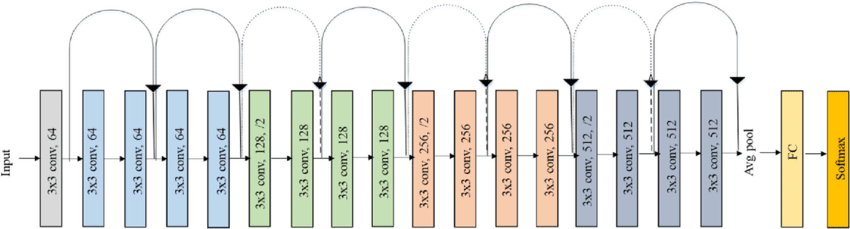

In [ ]:
def resnet18():

  input_im = Input(shape=(32, 32, 3), name="Input") # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3), name="ZeroPadding")(input_im)

  # 1st STAGE:

  if method == 1:  #using strides
    stride_dim = 2
  else:  #fixed spectral pooling OR diffstride
    stride_dim = 1


  x = Conv2D(64, kernel_size=(7, 7), strides=(stride_dim, stride_dim), name="Conv2D_1")(x)
  if method==2:  #fixed spectral pooling
    fixed1 = fixed_spectral_pool()   # initialization of the layer used in the current convolution
    x = fixed1(x)
  elif method==3:
    diffstride1 = diffstride_spectral_pool()   # initialization of the layer used in the current convolution
    x = diffstride1(x)
  x = BatchNormalization(name="BatchNormalization_1")(x)
  x = ReLU(name="ReLU_1")(x) 

  x = MaxPooling2D((3, 3), strides=(2, 2), name="MaxPooling_1")(x) 



  # 2nd STAGE:

  for i in range(4):   # from conv2_x to conv5_x
    name=str(i+2)
    if i == 0:  # conv2_x
        # For sub-block 1 the Residual/Convolutional block is not needed
        x = identity_block(x, filter_size[i],name+"_1")
        x = identity_block(x, filter_size[i],name+"_2")

    else: # conv3_x -> conv5_x
        # One Residual/Convolutional Block followed by  one Identity block
        # The filter size will go on increasing by a factor of 2
        #filter_size = filter_size*2
        x = residual_block(x, filter_size[i], stride_n[i-1], s_residual[i-1], name)
        x = identity_block(x, filter_size[i], name)


  # 3rd STAGE:
  # ends with global average pooling and dense connection

  x = GlobalAveragePooling2D(name="GlobalAveragePooling")(x)
  
  x = Flatten(name="Flatten")(x)

  x = Dense(dataset_type,  activation='softmax', name="DenseLayer")(x)   # dataset_type stands for the number of output classes

  # define the model 
  model = Model(inputs=input_im, outputs=x, name='Resnet18')

  return model

#Model initialization#

In [ ]:
init_lr = PiecewiseConstantDecay(boundaries,values)

model = resnet18()
model.compile(optimizer=SGD(init_lr,momentum), loss=CategoricalCrossentropy(False, label_smoothing), metrics=[CategoricalAccuracy()]) 

# METHOD 1 : working with Spatial pooling#

In [ ]:
model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
ZeroPadding (ZeroPadding2D)     (None, 38, 38, 3)    0           Input[0][0]                      
__________________________________________________________________________________________________
Conv2D_1 (Conv2D)               (None, 16, 16, 64)   9472        ZeroPadding[0][0]                
__________________________________________________________________________________________________
BatchNormalization_1 (BatchNorm (None, 16, 16, 64)   256         Conv2D_1[0][0]                   
___________________________________________________________________________________________

###Training (method 1)

In [ ]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=epochs)

Epoch 1/150
391/391 [==============================] - 484s 1s/step - loss: 2.0756 - categorical_accuracy: 0.3777 - val_loss: 1.8043 - val_categorical_accuracy: 0.4650
Epoch 2/150
391/391 [==============================] - 19s 49ms/step - loss: 1.9801 - categorical_accuracy: 0.3583 - val_loss: 2.0842 - val_categorical_accuracy: 0.3524
Epoch 3/150
391/391 [==============================] - 19s 48ms/step - loss: 1.7392 - categorical_accuracy: 0.5020 - val_loss: 1.7323 - val_categorical_accuracy: 0.5158
Epoch 4/150
391/391 [==============================] - 19s 49ms/step - loss: 1.6314 - categorical_accuracy: 0.5724 - val_loss: 1.6944 - val_categorical_accuracy: 0.5364
Epoch 5/150
391/391 [==============================] - 19s 49ms/step - loss: 1.5540 - categorical_accuracy: 0.6171 - val_loss: 1.6221 - val_categorical_accuracy: 0.5828
Epoch 6/150
391/391 [==============================] - 19s 48ms/step - loss: 1.4942 - categorical_accuracy: 0.6522 - val_loss: 1.5658 - val_categorical_accu

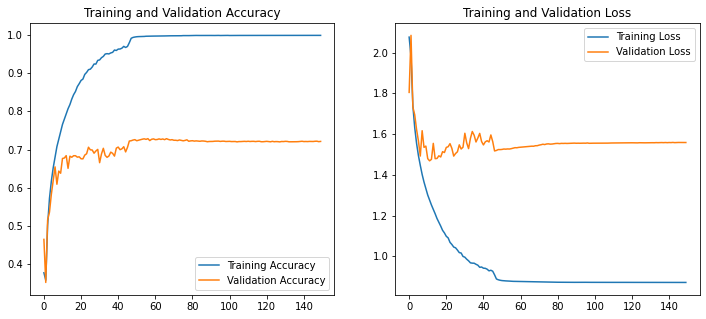

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Evaluation (method 1)

In [ ]:
result = model.evaluate(test_dataset)
print(result)

40/40 [==============================] - 25s 617ms/step - loss: 1.5253 - categorical_accuracy: 0.7334
[1.5253353118896484, 0.7333999872207642]


In [ ]:
i = 0
for batch in test_dataset:
    #print(len(batch))
    img = batch[0][0]
    label = batch[1][0]
    print(label)
    #plt.imshow(img)
    pred = model.predict(batch[0])
    print(pred[0])
    print("\n")
    if i == 4:
        break
    i+=1

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
[0.019503   0.01994213 0.01961653 0.01909813 0.02125715 0.01864953
 0.02113668 0.8204237  0.01936617 0.02100691]


tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
[0.02057913 0.02144856 0.03841958 0.48618636 0.02212025 0.02760915
 0.02869631 0.29377678 0.03359932 0.02756465]


tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
[0.8115452  0.02059105 0.01896813 0.02099984 0.02225122 0.02055271
 0.02082728 0.02229058 0.02103032 0.02094379]


tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
[0.01937087 0.01983807 0.01960383 0.01846434 0.02000399 0.0196861
 0.82426226 0.01989693 0.01943529 0.01943827]


tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)
[0.02236725 0.01954879 0.01947798 0.02174004 0.02089737 0.01897609
 0.01971065 0.0203266  0.01781173 0.8191434 ]




# METHOD 2 : working with Fixed Spectral pooling#

In [ ]:
model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
ZeroPadding (ZeroPadding2D)     (None, 38, 38, 3)    0           Input[0][0]                      
__________________________________________________________________________________________________
Conv2D_1 (Conv2D)               (None, 32, 32, 64)   9472        ZeroPadding[0][0]                
__________________________________________________________________________________________________
fixed_spectral_pool (fixed_spec (None, 16, 16, 64)   2           Conv2D_1[0][0]                   
___________________________________________________________________________________________

###Training (method 2)

In [ ]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=epochs)

Epoch 1/150
391/391 [==============================] - 363s 915ms/step - loss: 1.9115 - categorical_accuracy: 0.4161 - val_loss: 1.7654 - val_categorical_accuracy: 0.4830
Epoch 2/150
391/391 [==============================] - 10s 25ms/step - loss: 2.1765 - categorical_accuracy: 0.3023 - val_loss: 1.9718 - val_categorical_accuracy: 0.3380
Epoch 3/150
391/391 [==============================] - 10s 25ms/step - loss: 1.8364 - categorical_accuracy: 0.4375 - val_loss: 1.7629 - val_categorical_accuracy: 0.4730
Epoch 4/150
391/391 [==============================] - 10s 25ms/step - loss: 1.7073 - categorical_accuracy: 0.5227 - val_loss: 1.6807 - val_categorical_accuracy: 0.5408
Epoch 5/150
391/391 [==============================] - 10s 25ms/step - loss: 1.5917 - categorical_accuracy: 0.5931 - val_loss: 1.6584 - val_categorical_accuracy: 0.5586
Epoch 6/150
391/391 [==============================] - 10s 25ms/step - loss: 1.5070 - categorical_accuracy: 0.6461 - val_loss: 1.5482 - val_categorical_a

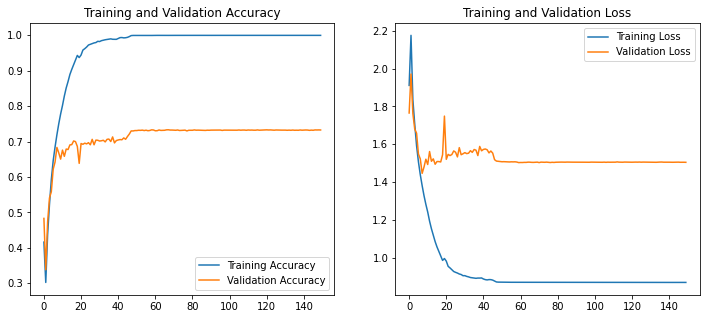

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)  #epochs

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Evaluation (method 2)

In [ ]:
result = model.evaluate(test_dataset)
print(result)

40/40 [==============================] - 21s 512ms/step - loss: 1.4489 - categorical_accuracy: 0.7570
[1.4489073753356934, 0.7570000290870667]


In [ ]:
i = 0
for batch in test_dataset:
    #print(len(batch))
    img = batch[0][0]
    label = batch[1][0]
    print(label)
    #plt.imshow(img)
    pred = model.predict(batch[0])
    print(pred[0])
    print("\n")
    if i == 4:
        break
    i+=1

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
[0.01968017 0.01970926 0.01975965 0.01983301 0.02010104 0.02103393
 0.01977871 0.8208864  0.01977117 0.0194467 ]


tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
[0.02511598 0.02926845 0.03013289 0.18343818 0.5749331  0.02693746
 0.03186053 0.03616179 0.02885958 0.03329206]


tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
[0.8210396  0.01979735 0.01998534 0.01968154 0.02011069 0.02004333
 0.01978417 0.02005967 0.0197873  0.01971087]


tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
[0.01989715 0.01979395 0.02047629 0.0205435  0.02031722 0.02002217
 0.81943095 0.01994506 0.02001965 0.01955404]


tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)
[0.01972657 0.01920829 0.01965621 0.01967505 0.02075722 0.01978524
 0.01959241 0.02033189 0.02006174 0.8212053 ]




# METHOD 3 : working with Diffstride (Learnable spectral pooling)#

In [ ]:
model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
ZeroPadding (ZeroPadding2D)     (None, 38, 38, 3)    0           Input[0][0]                      
__________________________________________________________________________________________________
Conv2D_1 (Conv2D)               (None, 32, 32, 64)   9472        ZeroPadding[0][0]                
__________________________________________________________________________________________________
diffstride_spectral_pool (diffs (None, None, None, 6 2           Conv2D_1[0][0]                   
___________________________________________________________________________________________

###Training (method 3)

Since the training was heavier (also the size of the strides is trained) and since from an initial training we saw that the accuracy grows fast and already around the 30 epochs stabilizes, we introduced early stopping in order to avoid useless long trainings, and also to save GPU's availability on Colab.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)   
history = model.fit(train_dataset,validation_data=val_dataset,epochs=40,callbacks=[callback]) 

Epoch 1/40


2022-04-08 10:45:25.775154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-08 10:45:42.137983: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


391/391 [==============================] - 422s 1s/step - loss: 1.7430 - categorical_accuracy: 0.5112 - val_loss: 1.6491 - val_categorical_accuracy: 0.5670
Epoch 2/40
391/391 [==============================] - 81s 207ms/step - loss: 1.7076 - categorical_accuracy: 0.5369 - val_loss: 1.7491 - val_categorical_accuracy: 0.5228
Epoch 3/40
391/391 [==============================] - 84s 215ms/step - loss: 1.4473 - categorical_accuracy: 0.6934 - val_loss: 1.4723 - val_categorical_accuracy: 0.6772
Epoch 4/40
391/391 [==============================] - 84s 216ms/step - loss: 1.3307 - categorical_accuracy: 0.7624 - val_loss: 1.4926 - val_categorical_accuracy: 0.6702
Epoch 5/40
391/391 [==============================] - 84s 216ms/step - loss: 1.2579 - categorical_accuracy: 0.8020 - val_loss: 1.3729 - val_categorical_accuracy: 0.7336
Epoch 6/40
391/391 [==============================] - 85s 217ms/step - loss: 1.2006 - categorical_accuracy: 0.8371 - val_loss: 1.3195 - val_categorical_accuracy: 0.7660

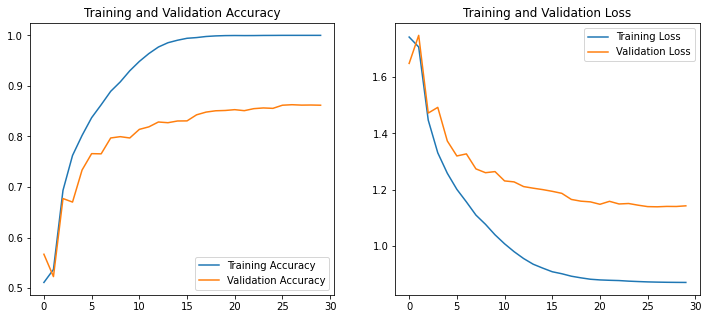

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Evaluation (method 3)

In [ ]:
result = model.evaluate(test_dataset)
print(result)

40/40 [==============================] - 21s 530ms/step - loss: 1.1260 - categorical_accuracy: 0.8692
[1.125975489616394, 0.8691999912261963]


In [ ]:
i = 0
for batch in test_dataset:
    #print(len(batch))
    img = batch[0][0]
    label = batch[1][0]
    print(label)
    #plt.imshow(img)
    pred = model.predict(batch[0])
    print(pred[0])
    print("\n")
    if i == 4:
        break
    i+=1

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
[0.01841317 0.01985796 0.0220035  0.01986035 0.01850595 0.02149966
 0.02130155 0.8184927  0.01995684 0.02010844]


tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
[0.02645488 0.02877211 0.05858696 0.74298775 0.02742656 0.01858768
 0.02231297 0.02126259 0.02445459 0.02915392]


tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
[0.7851088  0.02353391 0.02433935 0.02412393 0.02356472 0.02319595
 0.02450927 0.02373351 0.0252435  0.02264707]


tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
[0.0228784  0.02124427 0.02487052 0.02431308 0.02274332 0.0231018
 0.7945877  0.02293126 0.02174715 0.02158258]


tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)
[0.01963515 0.02115699 0.02031397 0.02036622 0.01974215 0.01945878
 0.01833073 0.01923265 0.01880355 0.8229597 ]




#Experiments

In the table we reported some of the experiments that were performed with strides on height and width of (2,2).
We have done training with different batch sizes and with or without mixup. 

The more significant results were obtained through a batch of 128 and no mix up. 

It is recognizable how the fixed spectral pooling brings improvements of about 2% in the accuray. But the best improvement, of about 10% in accuracy, is obtained through the method that also learns stride’s value.

For spatial and fixed spectral pooling, trainings lasted 150 epochs. For learnable strides pooling, 40 epochs were considered. Also, for method 3, early stopping was exploited: in fact it is computationally heavier, since also the value of the strides is trained. Also, from the first trainings done, we saw that after 30/40 epochs the accuracy stabilized, not increasing anymore.


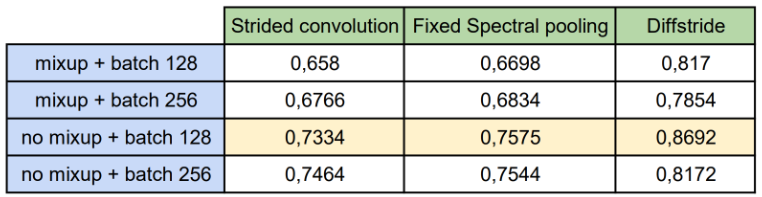

After having exploited these different setups, we have taken *no mixup* + *batch of 128* and we have done experiments changing strides sizes: (2,2,3), (3,1,3), (3,1,2) where the i-th number represents the size of strides used in the i-th residual block if the Resnet-18.

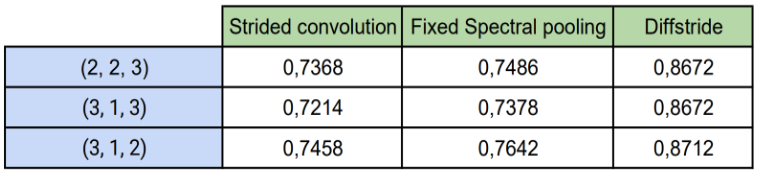

#Save and Load the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_saved_models = "/content/drive/MyDrive/ColabNotebooks/NN/models_saved/"

In [ ]:
filename = path_saved_models + "method_3.joblib"

###Save model

In [ ]:
joblib.dump(model, filename)

###Load a model

In [ ]:
loaded_model = joblib.load(filename)

##### evaluation and prediction example from loaded model



In [ ]:
result = loaded_model.evaluate(test_dataset)
print(result)

40/40 [==============================] - 3s 62ms/step - loss: 1.1514 - categorical_accuracy: 0.8538
[1.151355504989624, 0.8537999987602234]


In [ ]:
for batch in test_dataset:
  print(len(batch))
  break
img = batch[0][0]
label = batch[1][0]
print(label)

pred = loaded_model.predict(batch[0])
print(pred[0])

2
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
[0.01694095 0.0178556  0.01590339 0.01741557 0.01575356 0.01742633
 0.01550334 0.85348016 0.01653293 0.01318813]
